In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d

# Visualization parameter
plt.rcParams['figure.figsize'] = [10,6]

import random
import time

### Function Implementation
The Schwefel function is a continuous, multimodal, non-convex, deceptive (many local optima), and N-dimensional function with a global minimum of 0.

> $f_{schwefel}(x_1, x_2, ... x_N) = 418.98291 N - \sum_{i=1}^N x_i sin(\sqrt {|x_i|})$

It takes in N random numbers in a pre-defined range, processes them through the formula above, and returns a value. For example, if $N = 2$, we might randomly generate numbers $x_1 = 0$ and $x_2 = 0$, plug them into the Schwefel function, and get a value of 837.96582.

### Genetic Algorithm Goal
The goal of this project is to build a Genetic Algorithm such that, for some given number range for N random numbers, we can find a combination of N numbers to yield a value of 0 or close to 0 when inputted into our Schwefel function.

In [2]:
def schwefel(num_list):  
    return (418.98291*len(num_list)) - np.sum([x*np.sin(np.sqrt(np.absolute(x)))for x in num_list])

In [3]:
schwefel([0,0])

837.96582

Due to floating point errors, we can't *really* hit 0 consistently as `np.sin(np.pi)` yields $1.22\times10^{-16}$ where it should be 0. The value is, however, small enough to be negligible in the grand scheme of things, though.

In [4]:
schwefel([420.969 for i in range(10)])

0.00022735684069630224

Note, with a little bit of math, you can quickly find one of the solutions as all of the numbers you input into the Schwefel function is arbitrary. You can practically solve it by graphing these two equations on Desmos or whatever graphing calculator software you have.
> $y = 418.98291$

> $y = sin(\sqrt {|x_i|})$

### Quick Visualization
We can plot the full extent of the Schwefel function's range for $N = 2$ by plotting the Schwefel function value of every combination of those two numbers onto a third axis to make a 3-Dimensional visualization of the Schwefel fitness landscape.

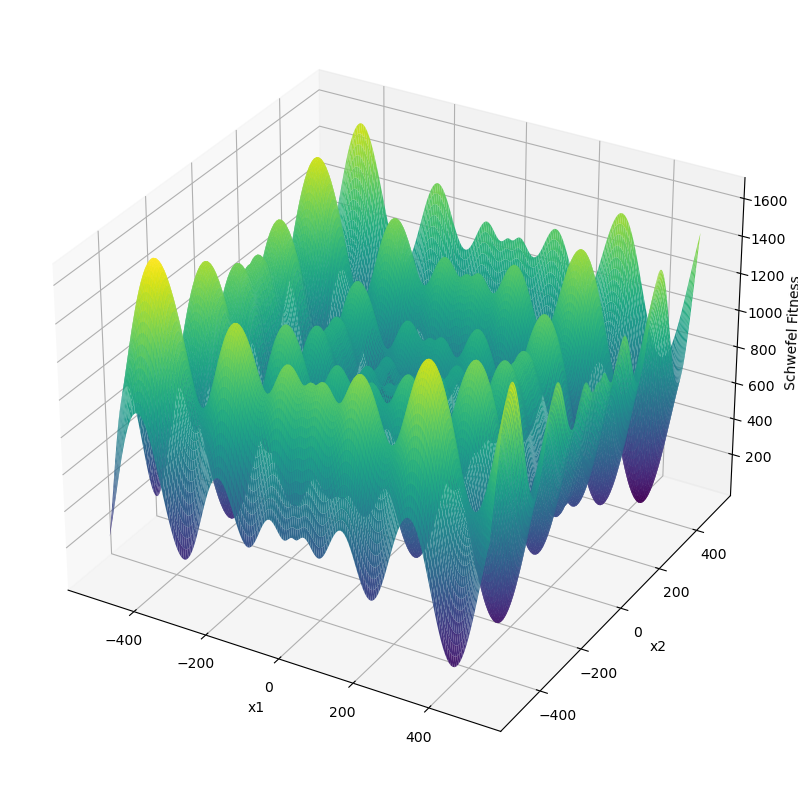

In [5]:
# Visualization of 2-Dimensional Schwefel function (3-D Fitness landscape visualization)
# Schwefel function modified for graphing convenience
def schwefel2(x, y):  
    return (418.98291*2) - ((x*np.sin(np.sqrt(np.absolute(x))))+(y*np.sin(np.sqrt(np.absolute(y)))))

x1 = np.linspace(-512, 512, 200)
x2 = np.linspace(-512, 512, 200)

X1, X2 = np.meshgrid(x1, x2)
results = schwefel2(X1, X2)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, results, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Schwefel Fitness')
plt.show()

## Real-Valued GA Approach
- Representation and Population: 100 randomly generated lists of 10 real numbers.
- Parents selected via Tournament Selection (n=2)
- Crossover (Pc = 0.9): Uniform, Whole Arithmetic
- Mutation (Pm = 1/10 = 0.1): Uniform
- Survivor Selection: Top 100 of Parents+Offspring pool
- Run for 500 generations and see how close we get.

In [6]:
# Population Init for 100 randomly generated genotypes
population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]

# This line sorts our population by the values of its schwefel fitness value
population.sort(key=schwefel)
# Access scores via [schwefel(i) for i in population]

In [7]:
# Mutation Operator - Mutating each number in a chromosome by randomly selecting another number in range

# Toggle parameters here
mrate = 0.1 # Per bit

# Takes in one chromosome and mutates each gene
def mutate(geno):
    return [random.uniform(-512, 512) if(random.uniform(0,1)<=mrate) else i for i in geno]
# Mutate with [mutate(i) for i in population]

In [8]:
# Crossover Operator - Taking 2 chromosomes and doing uniform whole arithmetic recombination

# Uniform, so crossover parameter is 0.5. Takes equal influence from both parents, returns identical children
alpha = 0.5
xrate = 0.9 # Per crossover operation, else copy parents

# Takes in two chromosomes and returns two new chromosomes
def cross(geno1, geno2):
    if(random.uniform(0,1)<=xrate):
        child1 = [alpha*geno1[i]+(1-alpha)*geno2[i] for i in range(len(geno1))]
        child2 = [alpha*geno2[i]+(1-alpha)*geno1[i] for i in range(len(geno2))]
        return [child1, child2]
    return [geno1, geno2]
# Add to population with population+cross(a,b)

In [9]:
# Parent Selector - Tournament selection. Tournament participants are uniformly random, selection grabs top fitness
# Contestants picked without replacement, n = tournament size, replaced after tournament
n = 2

def parent_sel(population):
    # Cumulative sum of ranking probabilities used here for random choice selection
    
    parents = []
    
    # Repeat process twice to get 2 parents for reproduction
    for i in range(2):
        # Set up copy for easier management
        copy_pool = population.copy()
        
        # Pick n contestants without replacement and sort by fitness    
        tourn_pool = [copy_pool.pop(random.randint(0, len(copy_pool)-1)) for i in range(n)]
        tourn_pool.sort(key=schwefel)
        # Just grab the best
        parents = parents+[tourn_pool[0]]

    return parents
# Have crossover call with cross(*parents)

In [10]:
# Survival Selector - Parents and Offsprings competing together
psize = 100

# Deterministic selection: Just picks Top 100 by dropping the worst (highest fitness) instead of sorting the list
def det_surv(pop):
    pop.sort(key=schwefel)
    return pop[:psize]

In [27]:
# Main evolution loop: Takes in a Population and evolves it. Takes in a recorder list and records progress.
def realGA(population, recorder):
    # Each Generation:
    for i in range(500):
        # Make 100 Kids
        for i in range(50):
            # Parent Selection
            parents = parent_sel(population)

            # Variation Operators on Offspring
            children = cross(*parents)
            children = [mutate(i) for i in children]
            population = population+children

        # Survival Selection
        population = det_surv(population)
        # Records Schwefel Score of best performer
        recorder.append(schwefel(population[0]))
    # Return results as a tuple after we're done
    return population, recorder
# Get population and recorder with results[0], results[1], respectively

Sorting is called 51 times per loop:
- Once on the *tournament pool* of size *n* every time we use tournament selection to generate children (50 times)
- Once on the *full population* of size *200* to sort the parent+offspring population for survival selection (1 time)

In [26]:
# ONE TRIAL

# 4 Parameters to be set:
xrate = 0.9
alpha = 0.5
mrate = 0.1
n = 2

start_time = time.time()

# Initialize population and recorder
population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]
recorder=[]

# Make sure to only run it once to save computing time
results = realGA(population, recorder)

population = results[0]
print(f"Number of records: {len(results[1])}")
print("---")
print(f"Best Chromosome: {population[0]}")
print(f"Schwefel Score: {schwefel(population[0])}")
print("--- %s seconds ---" % (time.time() - start_time))

Number of records: 500
---
Best Chromosome: [420.9138671281654, 421.07901497276276, 421.17605857505123, 420.4288330192966, 420.7842879974145, 420.7781311262983, 421.0409216309405, 418.46148814176485, 421.54592050383576, 420.4692493434343]
Schwefel Score: 0.9196120425722256
--- 6.194301128387451 seconds ---


In [38]:
# Function to run N trials + have DataFrame
def test_trials(n):
    data = []
    for trial in range(n):
        # Initialize population and recorder
        population = [[random.uniform(-512, 512) for i in range(10)] for i in range(100)]
        # Keeping track of best performance over time for visualization purposes
        # Recorder keeps initialized performance as a reference
        f_progress = [min([schwefel(i) for i in population])]

        results = realGA(population, f_progress)

        # Get progress of ALL runs
        data.append(results[1])
    # Return DataFrame
    return pd.DataFrame(data)

# Remember to save as variable to not call this long code more than once

In [39]:
# Default Parameters used. 30 Trials

start_time = time.time()

data_df = test_trials(30)

print("--- %s seconds ---" % (time.time() - start_time))

--- 191.19003796577454 seconds ---


In [40]:
# We can visualize the table like so
data_df.index += 1
data_df.index.name = "Trial Number"
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
Trial Number,,,,,,,,,,,,,,,,,,,,,
1,2896.227296,2809.143765,2809.143765,2809.143765,2809.143765,2809.143765,2809.143765,2809.143765,2755.517468,2755.517468,...,0.405902,0.405902,0.405902,0.405902,0.405902,0.405902,0.405902,0.405902,0.405902,0.396225
2,2351.062514,2351.062514,2351.062514,2351.062514,2351.062514,2351.062514,2351.062514,2351.062514,2351.062514,2351.062514,...,1.409827,1.409827,1.409827,1.409827,1.409827,1.400455,1.400455,1.400455,1.400455,1.400455
3,2179.335301,2179.335301,2179.335301,2179.335301,2179.335301,1868.090299,1868.090299,1868.090299,1868.090299,1868.090299,...,0.687019,0.687019,0.687019,0.685484,0.685484,0.684661,0.684383,0.684383,0.684314,0.684314
4,3050.701586,2960.391862,2960.391862,2935.252881,2935.252881,2935.252881,2935.252881,2866.653608,2606.212962,2506.282837,...,0.870745,0.870705,0.870705,0.870705,0.870705,0.870705,0.870705,0.870705,0.870705,0.870705
5,2881.330366,2881.330366,2881.330366,2881.330366,2874.545093,2874.545093,2593.618210,2593.618210,2593.618210,2348.628563,...,1.096798,1.096798,1.096798,1.096798,1.096798,1.096798,1.096798,0.953902,0.953902,0.953902


In [47]:
# Function that reports convergence
# Takes in some results, aggregates, and responds with time to converge to score N
def conv(df, n, label, param):
    average_df = df.mean(axis=0).to_frame(name="Fit")
    
    # Conditional exists because it's very possible the algorithm won't converge in time or converge at all
    if (len(average_df[average_df['Fit']<n])>0):
        print(f"On average, a Genetic Algorithm with a {label} of {param} reaches Schwefel < {n} at Generation {average_df[average_df['Fit']<n].iloc[0].name}")
    else:
        print(f"On average, a Genetic Algorithm with a {label} of {param} did not reach Schwefel < {n} within the time limit") 

In [48]:
# We can also see the average trajectory of each of these runs and see how long it takes for them to converge
conv(data_df, 10, "Parameter Set", "DEFAULT")

On average, a Genetic Algorithm with a Parameter Set of DEFAULT reaches Schwefel < 10 at Generation 282


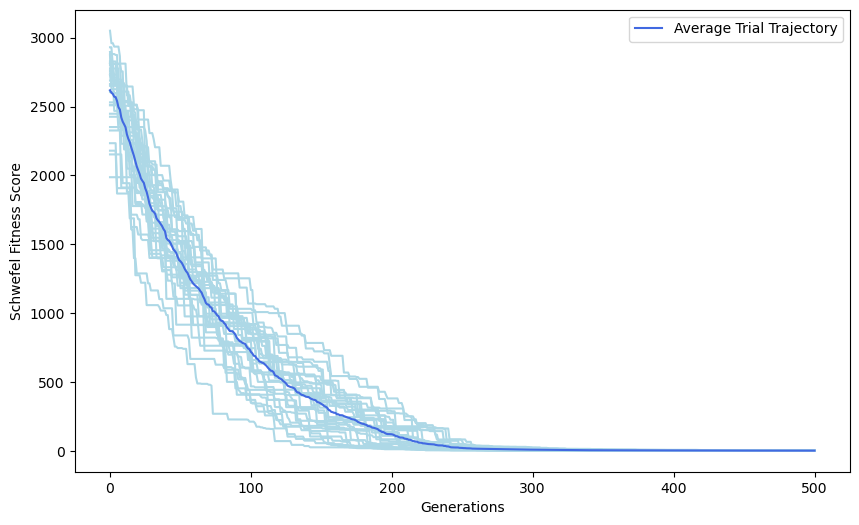

In [42]:
# Of course, we can also graph the results
for i in range(30):
    data_df.iloc[i].plot(color="lightblue", label="_nolegend_")
data_df.mean(axis=0).plot(color="royalblue", label="Average Trial Trajectory")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Generations")
plt.legend()
plt.show()

### Parameter Tuning
#### Tournament Sizes

On average, a Genetic Algorithm with a Tournament Size of 2 reaches Schwefel < 10 at Generation 271
--- 191.59006595611572 seconds ---
On average, a Genetic Algorithm with a Tournament Size of 6 reaches Schwefel < 10 at Generation 121
--- 363.2922055721283 seconds ---
On average, a Genetic Algorithm with a Tournament Size of 10 reaches Schwefel < 10 at Generation 81
--- 527.4209129810333 seconds ---
On average, a Genetic Algorithm with a Tournament Size of 15 reaches Schwefel < 10 at Generation 61
--- 735.9129650592804 seconds ---
On average, a Genetic Algorithm with a Tournament Size of 20 reaches Schwefel < 10 at Generation 58
--- 937.2647840976715 seconds ---


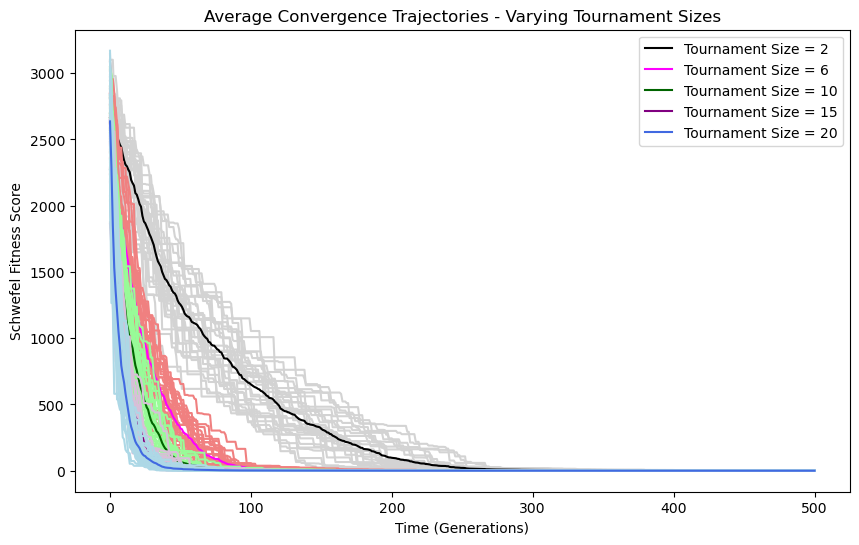

In [50]:
# This time, with varying Tournament Sizes
tsizes=[2, 6, 10, 15, 20]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    n = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Tournament Size", n)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Tournament Size = {n}")

plt.title("Average Convergence Trajectories - Varying Tournament Sizes")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
n=2

#### Crossover Rates

On average, a Genetic Algorithm with a Crossover Rate of 0.2 reaches Schwefel < 10 at Generation 152
--- 180.09258437156677 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.4 reaches Schwefel < 10 at Generation 156
--- 179.59990406036377 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.6 reaches Schwefel < 10 at Generation 178
--- 182.78119945526123 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.9 reaches Schwefel < 10 at Generation 293
--- 184.67887806892395 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 1.0 reaches Schwefel < 10 at Generation 482
--- 182.81989574432373 seconds ---


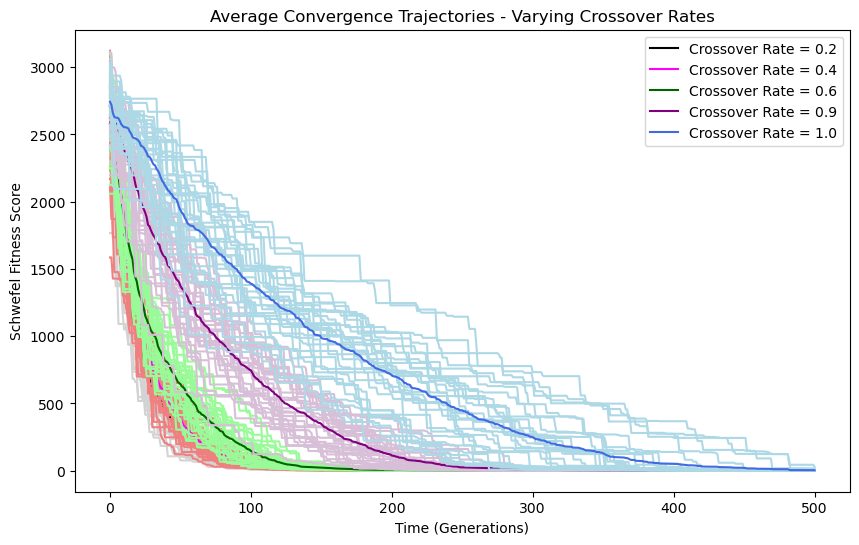

In [52]:
# This time, with varying Crossover Rates
tsizes=[0.2, 0.4, 0.6, 0.9, 1.0]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    xrate = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Crossover Rate", xrate)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Crossover Rate = {xrate}")

plt.title("Average Convergence Trajectories - Varying Crossover Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
xrate=0.9

On average, a Genetic Algorithm with a Crossover Rate of 0.0 reaches Schwefel < 10 at Generation 194
--- 179.82863903045654 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.05 reaches Schwefel < 10 at Generation 159
--- 177.9268205165863 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.1 reaches Schwefel < 10 at Generation 153
--- 181.64232563972473 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.15 reaches Schwefel < 10 at Generation 144
--- 179.60503768920898 seconds ---
On average, a Genetic Algorithm with a Crossover Rate of 0.2 reaches Schwefel < 10 at Generation 146
--- 179.85705184936523 seconds ---


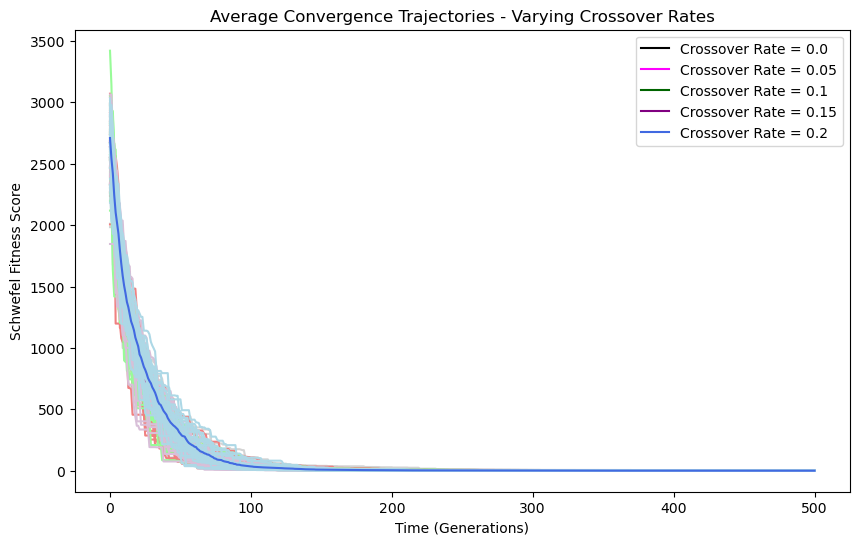

In [53]:
# Testing more Crossover Rates to see where things peak
tsizes=[0.0, 0.05, 0.1, 0.15, 0.2]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    xrate = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Crossover Rate", xrate)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Crossover Rate = {xrate}")

plt.title("Average Convergence Trajectories - Varying Crossover Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
xrate=0.9

#### Mutation Rates

On average, a Genetic Algorithm with a Mutation Rate of 0.0 did not reach Schwefel < 10 within the time limit
--- 187.8538191318512 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.1 reaches Schwefel < 10 at Generation 274
--- 182.24633288383484 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.3 did not reach Schwefel < 10 within the time limit
--- 183.8490605354309 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.5 did not reach Schwefel < 10 within the time limit
--- 187.01187586784363 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.7 did not reach Schwefel < 10 within the time limit
--- 186.2418885231018 seconds ---


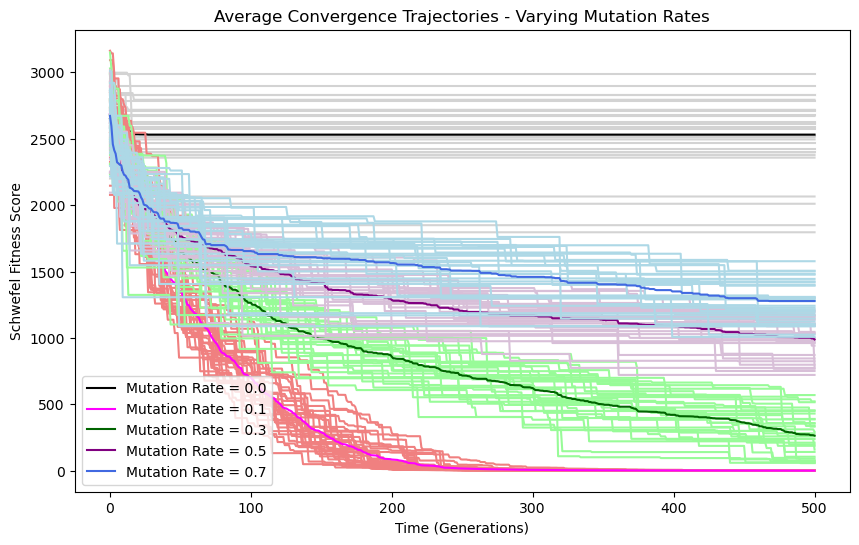

In [54]:
# This time, with varying Mutation Rates
tsizes=[0.0, 0.1, 0.3, 0.5, 0.7]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    mrate = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Mutation Rate", mrate)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Mutation Rate = {mrate}")

plt.title("Average Convergence Trajectories - Varying Mutation Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
mrate=0.1

On average, a Genetic Algorithm with a Mutation Rate of 0.01 reaches Schwefel < 10 at Generation 349
--- 183.02010798454285 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.03 reaches Schwefel < 10 at Generation 244
--- 180.88602566719055 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.05 reaches Schwefel < 10 at Generation 253
--- 181.77058339118958 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.07 reaches Schwefel < 10 at Generation 246
--- 184.02068758010864 seconds ---
On average, a Genetic Algorithm with a Mutation Rate of 0.1 reaches Schwefel < 10 at Generation 303
--- 185.44819831848145 seconds ---


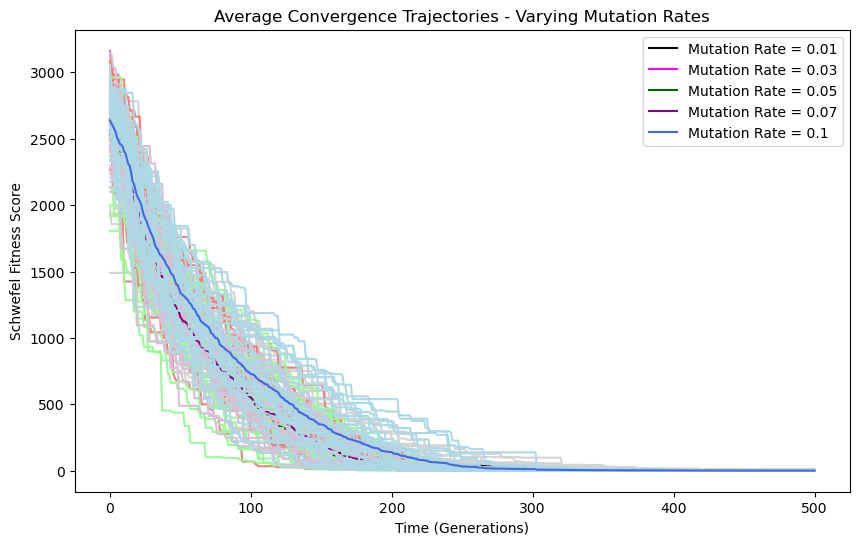

In [55]:
# Testing more Mutation Rates to see where things peak
tsizes=[0.01, 0.03, 0.05, 0.07, 0.1]
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    mrate = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Mutation Rate", mrate)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Mutation Rate = {mrate}")

plt.title("Average Convergence Trajectories - Varying Mutation Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
mrate=0.1

#### Alpha Values

On average, a Genetic Algorithm with a Alpha Value of 0.0 reaches Schwefel < 10 at Generation 190
--- 183.3713002204895 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.125 reaches Schwefel < 10 at Generation 210
--- 181.5658459663391 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.25 reaches Schwefel < 10 at Generation 248
--- 184.45112085342407 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.375 reaches Schwefel < 10 at Generation 278
--- 184.04294395446777 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.5 reaches Schwefel < 10 at Generation 282
--- 183.9260597229004 seconds ---


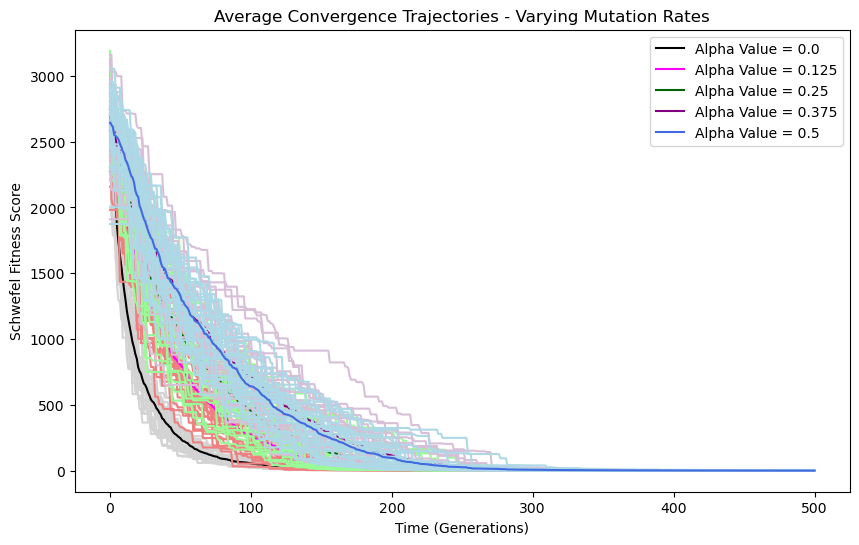

In [56]:
# This time, with varying Crossover Alpha Values
# We only need to test half of the parameter range as alpha=0.1 creates the same children as alpha=0.9 but in a different order
tsizes=[0.0, 0.125, 0.25, 0.375, 0.5]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    alpha = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Alpha Value", alpha)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Alpha Value = {alpha}")

plt.title("Average Convergence Trajectories - Varying Mutation Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
alpha = 0.5

On average, a Genetic Algorithm with a Alpha Value of 0.5 reaches Schwefel < 10 at Generation 273
--- 183.9279911518097 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.625 reaches Schwefel < 10 at Generation 269
--- 181.6724042892456 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.75 reaches Schwefel < 10 at Generation 253
--- 184.85862970352173 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.875 reaches Schwefel < 10 at Generation 207
--- 184.10885429382324 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 1.0 reaches Schwefel < 10 at Generation 185
--- 186.7103660106659 seconds ---


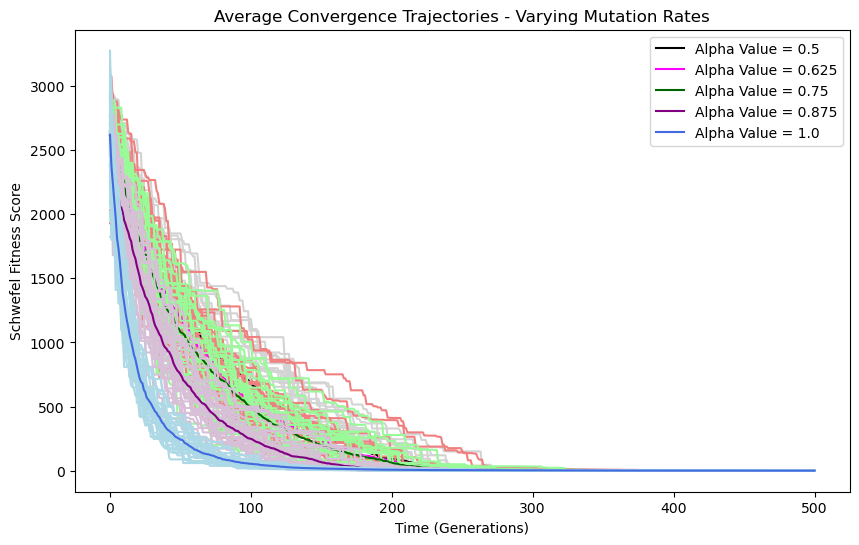

In [57]:
# Just to prove a point, these are the results for the other end of the spectrum
tsizes=[0.5, 0.625, 0.75, 0.875, 1.0]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    alpha = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Alpha Value", alpha)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Alpha Value = {alpha}")

plt.title("Average Convergence Trajectories - Varying Mutation Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
alpha = 0.5

On average, a Genetic Algorithm with a Alpha Value of 0.0 reaches Schwefel < 10 at Generation 182
--- 189.98751020431519 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.025 reaches Schwefel < 10 at Generation 164
--- 189.41368746757507 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.05 reaches Schwefel < 10 at Generation 181
--- 189.32259917259216 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.075 reaches Schwefel < 10 at Generation 189
--- 194.07153749465942 seconds ---
On average, a Genetic Algorithm with a Alpha Value of 0.1 reaches Schwefel < 10 at Generation 200
--- 189.71515250205994 seconds ---


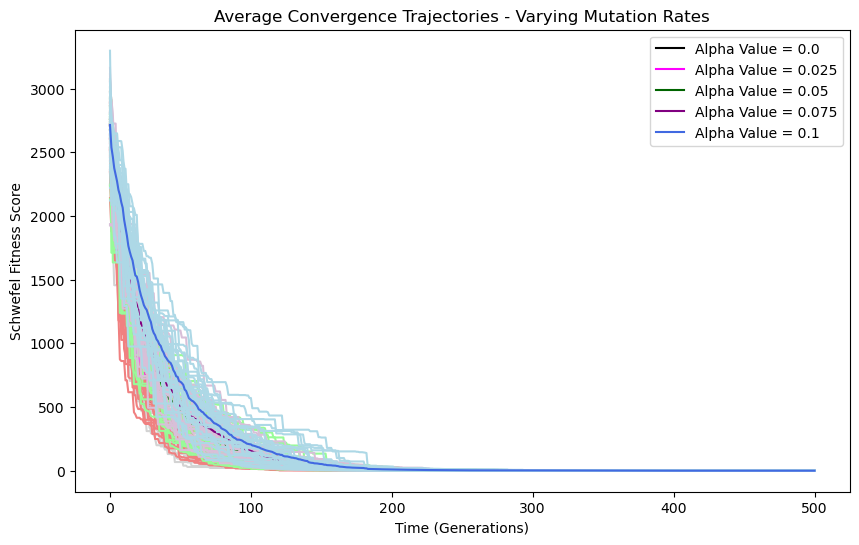

In [58]:
# Testing more Alpha Values to see where things peak
tsizes=[0.0, 0.025, 0.05, 0.075, 0.1]
# Graph visualization colors
color=[["lightgrey", "black"], ["lightcoral", "magenta"], ["palegreen", "darkgreen"], ["thistle", "purple"], ["lightblue", "royalblue"]]

# Test different conditions
for test in range(5):
    # Change Parameters per Test Bundle
    start_time = time.time()
    alpha = tsizes[test]

    # Plot Results of each Test Bundle
    data_df = test_trials(30)
    # Report Convergence
    conv(data_df, 10, "Alpha Value", alpha)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Graph results, needs to be on the same DataFrame for results to be on the same chart
    for i in range(30):
        data_df.iloc[i].plot(color=color[test][0], label="_nolegend_")
    data_df.mean(axis=0).plot(color=color[test][1], label=f"Alpha Value = {alpha}")

plt.title("Average Convergence Trajectories - Varying Mutation Rates")
plt.ylabel("Schwefel Fitness Score")
plt.xlabel("Time (Generations)")
plt.legend()
plt.show()

# Reset parameters
alpha = 0.5

## Binary GA Approach
- Representation and Population: 100 randomly generated lists of 10 binary numbers.
- Parents selected via Tournament Selection (n=2)
- Crossover (Pc = 0.9): Uniform, 2-Point
- Mutation (Pm = 1/100 = 0.01): Bit-flip
- Survivor Selection: Parents+Offspring
- Run for 500 generations and see how close we get.

In [15]:
# TODO: Pop init, cross, mutate, parent sel, survivor sel, terminate

In [14]:
a = '-'+''.join(str(random.randint(0, 1)) for i in range(9))

In [15]:
a
# [0,1,0 x 100] kinda just brute force 100 bits and convert to Ints

'-000001100'

In [19]:
a = 0b1111111111
str(a)

'1023'